In [2]:
from network_rs import Regressor
from train_rs import load_model
import os
import pandas as pd
import numpy as np
import torch
from network_rs import Regressor
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [19]:
path = '/home/qiaozhih/bliss/bliss/encoder/training_runs/00003-run/008500'
model_path = f'{path}_model.pt'
opt_path = f'{path}_opt.pt'
model = Regressor(6, 256, 1, 'cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Load pretrained model

In [20]:
reg, opt = load_model(model, optimizer, model_path, opt_path)
reg.to('cuda')

Regressor(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Prepare dataset

In [5]:
# dataset_name = 'test'
dataset_name = 'desc_dc2_run2.2i_dr6_truth_nona_val'
path = f'/home/qiaozhih/bliss/data/redshift/dc2/{dataset_name}.pkl'
photo_z = pd.read_pickle(path)
print("finish reading dataset!")
device = 'cuda'

print("start tensor dataset preparation!")
x = photo_z.values[:,:-1].astype(float)
y = photo_z.values[:, -1].astype(float)
x_train = np.array(x)
y_train = np.array(y)
tensor_x = torch.Tensor(x_train)
tensor_y = torch.Tensor(y_train)
custom_dataset = TensorDataset(tensor_x, tensor_y)     
dataloader = DataLoader(custom_dataset, batch_size=2048) 

finish reading dataset!
start tensor dataset preparation!


In [21]:
preds = []
trues = []
for idx, (x, y) in tqdm(enumerate(dataloader), unit='batch'):
    x = x.to(reg.device)
    y = y.to(reg.device)
    pred_this_batch = reg(x)
    preds.append(pred_this_batch)
    trues.append(y)
    

    if idx > 1000:
        break

1001batch [00:19, 51.37batch/s]


In [22]:
preds = torch.cat(preds)
trues = torch.cat(trues)

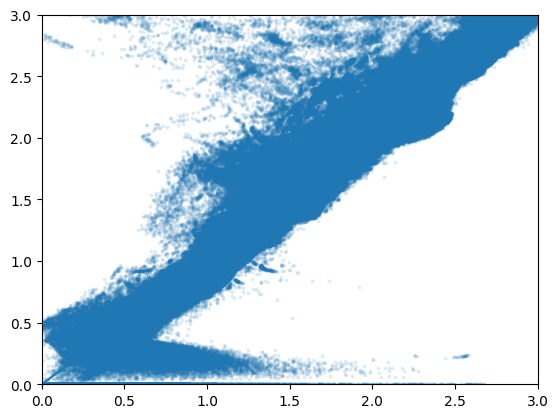

In [23]:
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.axline((0, 0), slope=1)
preds = preds.detach().cpu().numpy()
trues = trues.detach().cpu().numpy()
plt.scatter(preds, trues, alpha=0.1, s=3)

In [24]:
mse = mean_squared_error(trues, preds)
print(f'mse:{mse:03f}')

mse:0.027705


In [19]:
def split_as_train_val(df, test_size, random_state):
    """
    df: DataFrame
    test_size: float
    """
    return train_test_split(df, test_size=test_size, random_state=random_state)

In [20]:
dataset_name = 'desc_dc2_run2.2i_dr6_truth'
dir = '/home/qiaozhih/bliss/data/redshift/dc2'
path = os.path.join(dir, f'{dataset_name}.pkl')
print('reading dataset')
df = pd.read_pickle(path)
print('spliting dataset')
train_set, val_set = split_as_train_val(df, test_size=0.2, random_state=42)

reading dataset
spliting dataset


In [21]:
val_set

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,redshift
619426094,28.628424,28.360928,28.530945,28.520927,28.443455,28.414242,2.004280
218535396,27.933664,28.051760,28.114691,27.906181,27.525503,27.514055,1.038259
650468503,27.147121,27.219622,27.637611,27.576494,27.688025,27.774782,1.740793
715170698,28.241577,28.007156,28.024805,28.199308,28.254841,28.274261,2.640867
418921169,27.877953,27.366116,26.337194,25.898640,25.692059,25.557911,0.492239
...,...,...,...,...,...,...,...
753465567,28.912336,28.893301,28.737457,28.048784,27.923656,27.919037,0.851458
565022901,28.651915,28.683594,28.707062,28.675413,28.251764,27.994175,1.266076
160431308,25.652731,25.840134,25.529211,25.103371,24.691837,24.667850,1.020178
352966919,30.438229,28.430288,27.488882,27.065916,26.502975,25.757576,2.214542


In [22]:
train_set

,mag_u,mag_g,mag_r,mag_i,mag_z,mag_y,redshift
420264878,28.893278,28.310995,28.192881,28.228966,28.304777,28.309895,2.687127
301361480,29.696285,29.398193,28.889915,28.107597,27.693653,27.653664,0.953092
157357063,28.554583,28.350389,28.730545,28.723257,28.715927,28.766895,2.078191
503105071,29.407623,28.589308,28.345201,28.091566,27.731668,27.515924,1.854563
570167338,28.767902,28.619373,28.705866,28.804771,28.893524,28.953804,2.343827
...,...,...,...,...,...,...,...
415968276,26.105961,25.881731,25.924215,26.026272,26.055195,26.073969,2.108357
423734972,27.820425,27.186949,26.160376,25.961224,25.843485,25.770302,0.427643
127521863,29.052877,28.702248,27.938871,27.311457,27.156979,27.042944,0.657103
199900595,28.866217,28.764336,28.835918,28.923960,28.951096,29.004848,1.934726


In [24]:
train_set.reset_index(drop=True, inplace=True)
val_set.reset_index(drop=True, inplace=True)

In [26]:
print('saving training and validation dataset')
train_path = os.path.join(dir, f'{dataset_name}_train.pkl')
val_path = os.path.join(dir, f'{dataset_name}_val.pkl')
train_set.to_pickle(train_path)
val_set.to_pickle(val_path)

saving training and validation dataset
